# 부동산 허위매물 분류 해커톤

## Data Import


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/fakerealestate/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/fakerealestate/test.csv')
submit = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/fakerealestate/sample_submission.csv')

In [3]:
train.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1


In [4]:
test.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일
0,TEST_000,서류확인,223000000.0,530000,NaN,5.0,5.0,남향,1.0,1.0,불가능,NaN,7,Z86Th6S3K5,D플랫폼,2024-10-21
1,TEST_001,서류확인,150500000.0,590000,30.26,7.0,11.0,서향,1.0,1.0,불가능,16.0,11,G52Iz8V2B9,D플랫폼,2023-09-02
2,TEST_002,현장확인,47000000.0,200000,41.50,2.0,3.0,남서향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-04-03
3,TEST_003,서류확인,133000000.0,250000,31.35,5.0,6.0,남향,2.0,1.0,가능,NaN,5,C41wx1K6U9,B플랫폼,2024-09-19
4,TEST_004,현장확인,108000000.0,380000,23.14,2.0,3.0,남향,1.0,1.0,불가능,NaN,0,Z68ZJ6F6L4,A플랫폼,2024-11-10


In [5]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes,columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) *100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ
summary(train)

data shape: (2452, 17)


,data type,#missing,%missing,#unique,min,max
ID,object,0,0.000000,2452,NaN,NaN
매물확인방식,object,0,0.000000,3,NaN,NaN
보증금,float64,0,0.000000,426,5000000.0,409000000.0
월세,int64,0,0.000000,76,0.0,750000.0
전용면적,float64,787,32.096248,800,17.5,49.97
해당층,float64,229,9.339315,21,1.0,21.0
총층,float64,16,0.652529,20,2.0,21.0
방향,object,0,0.000000,8,NaN,NaN
방수,float64,16,0.652529,2,1.0,2.0
욕실수,float64,18,0.734095,2,1.0,2.0


In [6]:
for i in [train,test]:
    i['제공플랫폼'] = i['제공플랫폼'].apply(lambda x: x.replace('플랫폼',''))
    i['게재일'] = pd.to_datetime(i['게재일'],format='%Y-%m-%d')
    i['년'] = i['게재일'].dt.year
    i['월'] = i['게재일'].dt.month
    i['일'] = i['게재일'].dt.day
    i['요일'] = i['게재일'].dt.weekday
del train['게재일'],test['게재일']

## EDA

- 결측치 : 전용면적(연속형),해당층,총층,방수,욕실수,총주차대수
- 총층와 해당층 관련된 유사관계
- 관리비: 0의 의미

In [7]:
df_tr = train.copy()
df_te = test.copy()

df_tr = df_tr.drop('ID',axis=1)
df_te = df_te.drop('ID',axis=1)

In [8]:
con_col = ['보증금','월세','전용면적','관리비','해당층','총층','방수','욕실수','총주차대수']
cat_col = [col for col in df_tr.columns if col not in con_col]
cat_col.remove('중개사무소')
cat_col.remove('허위매물여부')

### Total Distribution

In [9]:
con_col

['보증금', '월세', '전용면적', '관리비', '해당층', '총층', '방수', '욕실수', '총주차대수']

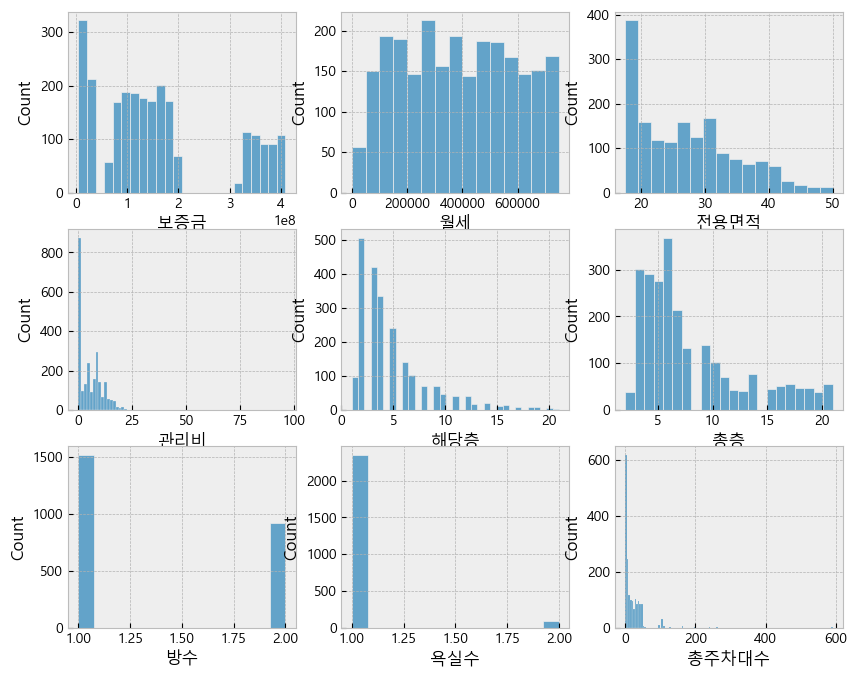

In [10]:
fig,ax = plt.subplots(3,3,figsize=(10,8))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.histplot(df_tr[col],ax=ax[i])

In [11]:
cat_col

['매물확인방식', '방향', '주차가능여부', '제공플랫폼', '년', '월', '일', '요일']

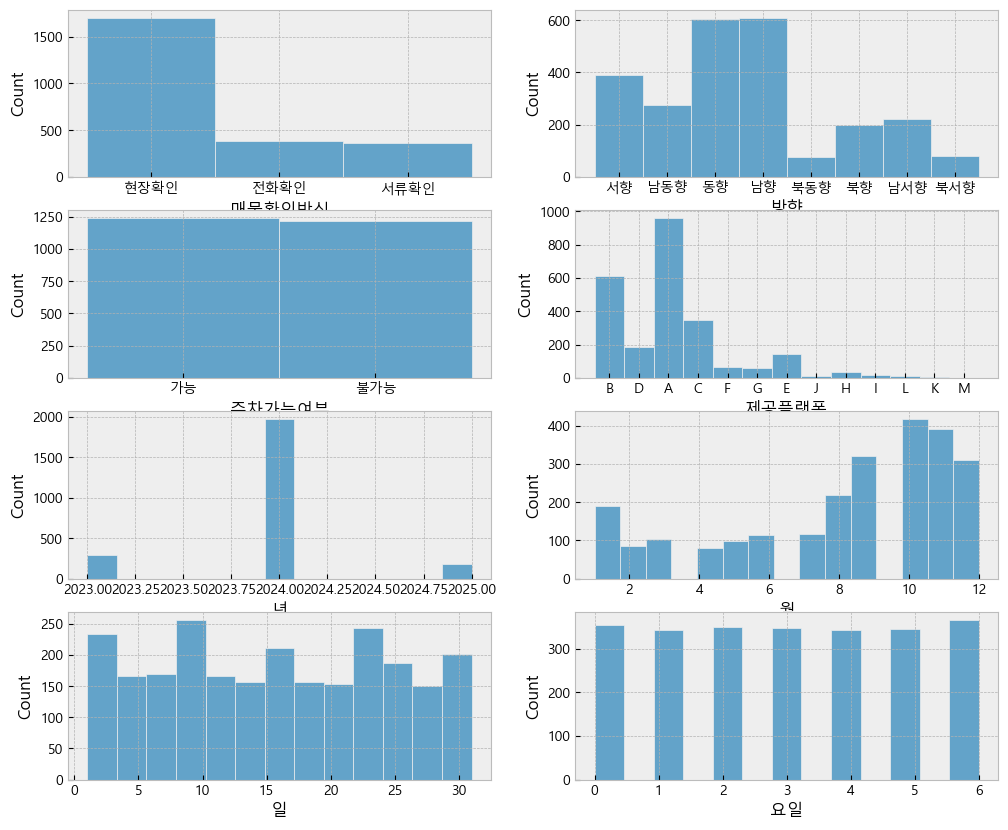

In [12]:
fig,ax = plt.subplots(4,2,figsize=(12,10))
ax = ax.flatten()

for i,col in enumerate(cat_col):
    sns.histplot(df_tr[col],ax=ax[i])

c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  func(*args, **kwargs)
c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


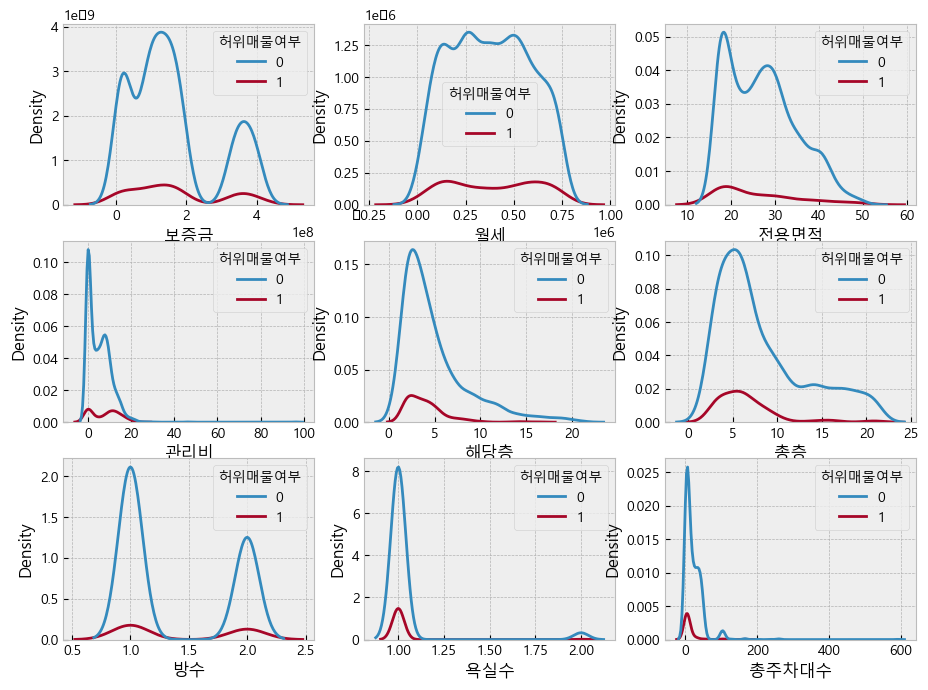

In [13]:
fig,ax = plt.subplots(3,3,figsize=(11,8))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.kdeplot(x=df_tr[col],hue=df_tr['허위매물여부'],ax=ax[i])

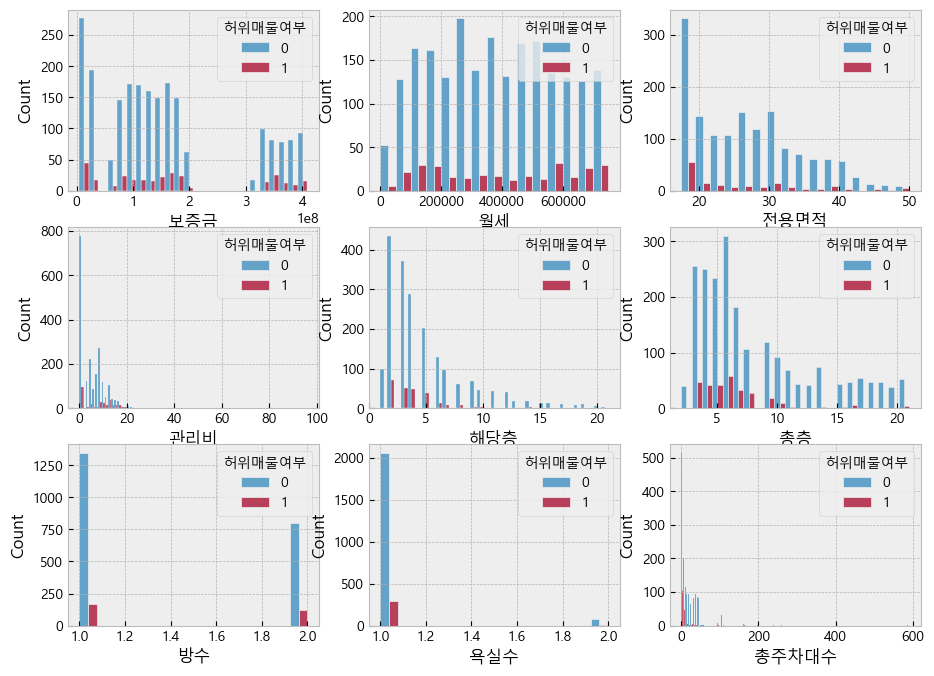

In [14]:
fig,ax = plt.subplots(3,3,figsize=(11,8))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.histplot(x=df_tr[col],hue=df_tr['허위매물여부'],ax=ax[i],multiple='dodge')

### 1.매물 확인방식

<Axes: xlabel='매물확인방식', ylabel='Count'>

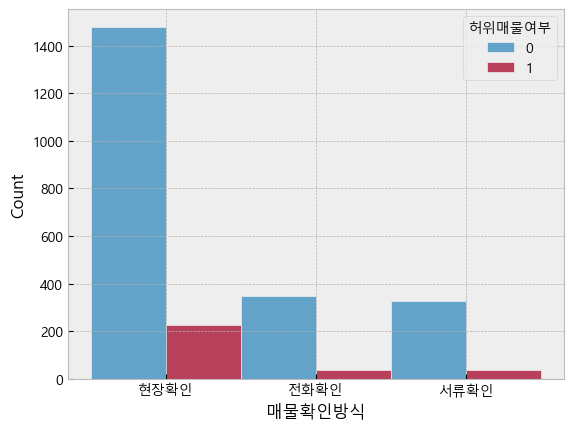

In [15]:
sns.histplot(x=df_tr['매물확인방식'],hue=df_tr['허위매물여부'],multiple='dodge')

### 2. 보증금 & 월세
- 허위매물 보증금/월세 분포도 전체 보증금/월세를를 따라감 => 별다른 전처리X
- 월세와 보증금 간의 관계: 일정부분의 상관관계?

<Axes: xlabel='보증금', ylabel='Count'>

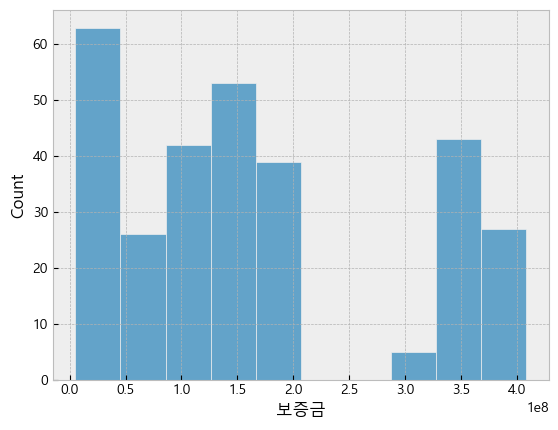

In [16]:
sns.histplot(x=df_tr['보증금'].loc[df_tr['허위매물여부']==1])

<Axes: xlabel='월세', ylabel='보증금'>

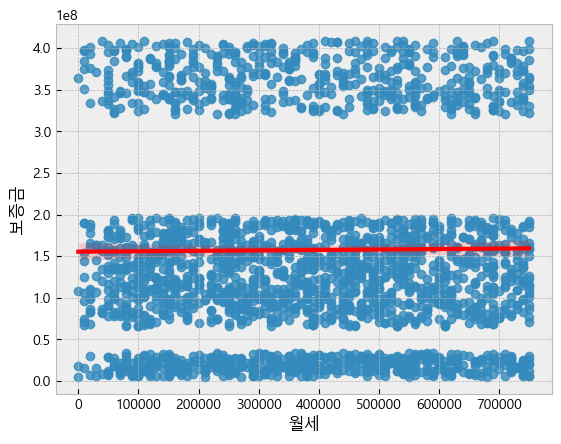

In [17]:
sns.regplot(x=df_tr['월세'],y=df_tr['보증금'],line_kws={'color':'red'})

### 3.전용면적
- 결측치가 존재 1/6정도(787개)
- 전용면적은 방의 갯수,월세,보증금 등 여럿 변수에 영향을 받는다.
- 최소면적인 17.5의 방이 300개
    - 당연하게도? 17.5인 방에 허위매물이 많음(**12%**)
    
- 월세 / 보증금과 그렇게 특이한 부분이 띄진 않음.
- 결측치 / 결측치가 아닌 data의 target 비율이 비슷함.


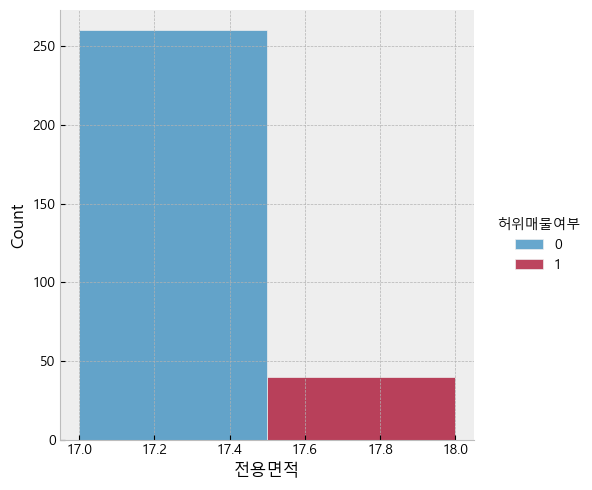

In [18]:
sns.displot(x=df_tr['전용면적'].loc[df_tr['전용면적']==17.5],hue=df_tr['허위매물여부'],multiple='dodge')

Text(0.5, 1.0, '허위매물의 전용면적 분포')

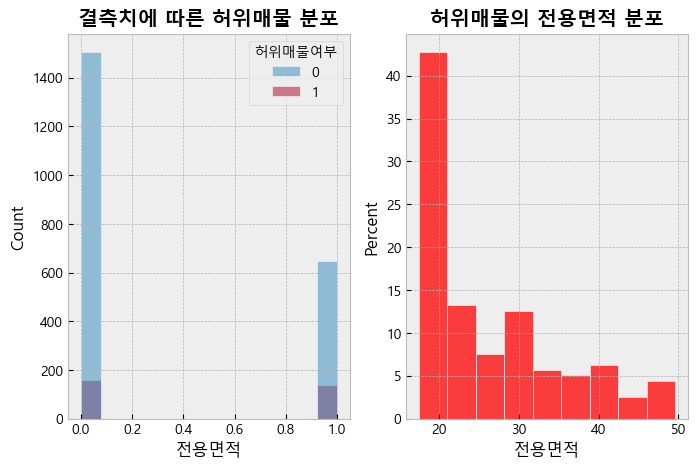

In [19]:
fig,ax = plt.subplots(1,2,figsize=(8,5))
sns.histplot(x=df_tr['전용면적'].isna(),hue=df_tr['허위매물여부'],ax=ax[0])
sns.histplot(df_tr['전용면적'].loc[df_tr['허위매물여부']==1], color='red', stat='percent',ax=ax[1])
ax[0].set_title('결측치에 따른 허위매물 분포',weight='bold')
ax[1].set_title('허위매물의 전용면적 분포',weight='bold')

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(11,7))
ax=ax.flatten()
sns.regplot(x='전용면적',y='보증금',data=df_tr,line_kws={'color':'black'},ax=ax[0])
sns.regplot(x='전용면적',y='월세',data=df_tr,line_kws={'color':'black'},ax=ax[1])
sns.scatterplot(x='전용면적',y='보증금',data=df_tr,hue='허위매물여부',ax=ax[2],alpha=0.7)
sns.scatterplot(x='전용면적',y='월세',data=df_tr,hue='허위매물여부',ax=ax[3],alpha=0.7)

### 4. 해당층 / 총층
- 해당층 // 총층의 값을 '층비율' 변수 정의로 하면 좋을듯.

- 총층이 결측치면 무조건 해당층도 결측치임. (총층:16개 / 해당층:229)
    - 총층 결측치는 삭제해도 괜찮을듯
    - 결측치 내부의 허위매물 비율도 별 특징 없는듯


In [20]:
df_tr.loc[df_tr['총층'].isna()][['총층','해당층','방수','욕실수']]

,총층,해당층,방수,욕실수
37,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN
153,NaN,NaN,NaN,NaN
339,NaN,NaN,NaN,NaN
456,NaN,NaN,NaN,NaN
515,NaN,NaN,NaN,NaN
546,NaN,NaN,NaN,NaN
686,NaN,NaN,NaN,NaN
952,NaN,NaN,NaN,NaN


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.histplot(x=df_tr['해당층'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[0])
ax[0].set_title('해당층 분포',weight='bold')

sns.histplot(x=df_tr['총층'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[1])
ax[1].set_title('총층 분포',weight='bold')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=df_tr['해당층'].isna(), hue=df_tr['허위매물여부'], ax=ax[0])
ax[0].set_title('해당층 결측치에 따른 허위매물 분포', weight='bold')

sns.countplot(x=df_tr['총층'].isna(), hue=df_tr['허위매물여부'], ax=ax[1])
ax[1].set_title('총층 결측치에 따른 허위매물 분포', weight='bold')
# Adding percentage labels on the bars
for a in ax:
    for p in a.patches:
        height = p.get_height()
        total = len(df_tr)
        a.text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

### 5. 방향

In [ ]:
sns.histplot(x=df_tr['방향'],hue=df_tr['허위매물여부'],multiple='dodge',stat='density')

### 6. 방수 / 욕실수
- 결측치가 별로 없음. (방수:16 / 욕실:18)
    - 방수,총층의 결측치(16개)가 모두 겹침(이부분은 제거하는게 맞을듯)
    - 결측치의 합집합은 1171 칼럼.
- 방 수에 따라서 허위매물에 영향을 끼치는게 있을듯. (특히 2개)

In [ ]:
df_tr[['전용면적','해당층','총층','방수','욕실수','총주차대수']][df_tr.isna().any(axis=1)]

In [ ]:
df_tr.loc[df_tr['방수'].isna() & df_tr['총층'].isna()][['전용면적','해당층','총층','방수','욕실수','총주차대수']]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=df_tr['방수'], hue=df_tr['허위매물여부'], ax=ax[0])
ax[0].set_title('방수에 따른 허위매물 분포', weight='bold')

sns.countplot(x=df_tr['욕실수'], hue=df_tr['허위매물여부'], ax=ax[1])
ax[1].set_title('욕실수에 따른 허위매물 분포', weight='bold')

# Adding percentage labels on the bars
for p in ax[0].patches:
    height = p.get_height()
    total = len(df_tr)
    ax[0].text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

for p in ax[1].patches:
    height = p.get_height()
    total = len(df_tr)
    ax[1].text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=df_tr['방수'].isna(), hue=df_tr['허위매물여부'], ax=ax[0])
ax[0].set_title('방수 결측치에 따른 허위매물 분포', weight='bold')

sns.countplot(x=df_tr['욕실수'].isna(), hue=df_tr['허위매물여부'], ax=ax[1])
ax[1].set_title('욕실수 결측치에 따른 허위매물 분포', weight='bold')
# Adding percentage labels on the bars
for a in ax:
    for p in a.patches:
        height = p.get_height()
        total = len(df_tr)
        a.text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

### 7.주차가능여부 / 총주차대수
- 총주차대수의 결측치에 꽤 많은 허위매물이 존재함.
- 100~300대의 주차공간이 가능한 매물 / 600개 이상의 주차공간을 가진 곳도 존재
    - 이상치로 치부할것인가?

- 주차가능여부가 불가능인데 총주차대수가 기록되어있는 데이터??
    - 총주차대수 결측치(696개) 중 주차불가능:585개

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x=df_tr['주차가능여부'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[0])
ax[0].set_title('주차가능여부에 따른 허위매물 분포', weight='bold')

sns.histplot(x=df_tr['총주차대수'], hue=df_tr['허위매물여부'], ax=ax[1],multiple='dodge')
ax[1].set_title('총주차대수에 따른 허위매물 분포', weight='bold')
ax[1].set_xlim(0,300)
# Adding percentage labels on the bars
for a in ax:
    for p in a.patches:
        height = p.get_height()
        total = len(df_tr)
        if height / total > 0.0:
            a.text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")
plt.tight_layout()

In [ ]:
df_miss = df_tr.loc[(df_tr['주차가능여부']=='불가능')][['허위매물여부','총주차대수']]
df_miss.fillna(-1, inplace=True)
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x=df_miss['총주차대수'].loc[df_miss['총주차대수']<50], hue=df_miss['허위매물여부'], ax=ax)
# Adding percentage labels on the bars
total = len(df_miss)
for p in ax.patches:
    height = p.get_height()
    if height / total > 0.0:
        ax.text(p.get_x() + p.get_width() / 2., height + 3,
                f'{height/total:.1%}', ha="center")

In [ ]:
sns.boxplot(df_tr['총주차대수'])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x=df_tr['총주차대수'].isna(), hue=df_tr['허위매물여부'], multiple='dodge', stat='percent', ax=ax[0])
ax[0].set_title('총주차대수 결측치에 따른 허위매물 분포', weight='bold')
sns.histplot(x=df_tr['총주차대수'].loc[df_tr['허위매물여부']==1], ax=ax[1],color='red')
ax[1].set_title('허위매물의 총주차대수 분포', weight='bold')

### 8. 관리비
- 관리비에 이상치가 몇개 존재하는듯
    - 삭제여부는 따로 보고 판단해야할듯
- 관리비가 0인 데이터가 많음 => 0의 의미?

In [ ]:
print(df_tr['관리비'].loc[df_tr['허위매물여부']==1].value_counts(normalize=True)[:5])
df_tr.loc[df_tr['관리비']>20].sort_values('관리비',ascending=False)

In [ ]:
#0인 허위매물의 비율이 30%
sns.displot(x=df_tr['관리비'].loc[df_tr['관리비']<20],hue=df_tr['허위매물여부'],multiple='dodge')

### 9. 중개사무소 / 제공플랫폼
- 중개사무소에서 사기가 시작될 확률이 높다.
    - 특정 중개사무소라고 많은 허위매물이 있는건 아님.


In [ ]:
df_tr.groupby('허위매물여부')['중개사무소'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(x=df_tr['제공플랫폼'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax)

# Adding percentage labels on the bars
total = len(df_tr)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2., height + 3,
                f'{height/total:.1%}', ha="center")

## Feature Engineering
- 파생변수 생성
    - 해당층 // 총층

- 결측치 16개 삭제 (public score 낮게 나옴)

In [ ]:
df_tr = df_tr.dropna(subset=['방수'],axis=0)
df_tr.shape

In [ ]:
cat_col.append('중개사무소')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_tr[cat_col] = df_tr[cat_col].apply(lambda x:le.fit_transform(x))
df_te[cat_col] = df_te[cat_col].apply(lambda x:le.fit_transform(x))
df_tr.head()

In [ ]:
plt.figure(figsize=(11,11))
sns.heatmap(df_tr.corr(),annot=True)

In [ ]:
print(df_tr.shape,df_te.shape)
X,y = df_tr.drop('허위매물여부',axis=1),df_tr['허위매물여부']
X_test = df_te

## 모델 설계

In [ ]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from optuna import trial,visualization
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score

from sklearn.model_selection import KFold

### RandomForest
- baseline : 0.72

In [ ]:
rf_val_preds = np.zeros(X.shape[0])
rf_test_preds = np.zeros(X_test.shape[0])

folds = KFold(n_splits=5,shuffle=True,random_state=2025)
f1_rf = []

for idx,(train_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'Fold {idx+1} / Fold {folds.n_splits}')
    X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val = X.iloc[val_idx],y.iloc[val_idx]

    rf = RandomForestClassifier(random_state=2025)
    rf.fit(X_train,y_train)
    rf_val_preds[val_idx] += rf.predict(X_val)
    
    
    print(f'Train f1_score: {f1_score(y_train,rf.predict(X_train))}')
    print(f'Valid f1_score: {f1_score(y_val,rf.predict(X_val))}')
    print('-'*30)

    rf_test_preds += rf.predict(X_test)/folds.n_splits
    
    f1_rf.append(f1_score(y_val,rf_val_preds[val_idx]))

print(f'F1-Score: {np.array(f1_rf).mean()}')

In [ ]:
sns.barplot(pd.Series(rf.feature_importances_,index=X_test.columns),orient='h')

### light-gbm
- 결측치 (16개) 삭제 : 0.826 (실제로는 낮게 측정되어 나옴)

#### baseline
- 0.845 : 말그대로 아무것도X
- 0.823 : 게재일 삭제, 년/월/일/요일 파생변수 생성


In [ ]:
lgb_val_preds = np.zeros(X.shape[0])
lgb_test_preds = np.zeros(X_test.shape[0])

folds = KFold(n_splits=5,shuffle=True,random_state=2025)
f1_lgb = []

for idx,(train_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'Fold {idx+1} / Fold {folds.n_splits}')
    X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val = X.iloc[val_idx],y.iloc[val_idx]

    lgb = LGBMClassifier(random_state=2025, objective='binary')
    lgb.fit(X_train,y_train)
    lgb_val_preds[val_idx] += lgb.predict(X_val)
    
    
    print(f'Train f1_score: {f1_score(y_train,lgb.predict(X_train))}')
    print(f'Valid f1_score: {f1_score(y_val,lgb.predict(X_val))}')
    print('-'*30)

    lgb_test_preds += lgb.predict(X_test)/folds.n_splits
    
    f1_lgb.append(f1_score(y_val,lgb_val_preds[val_idx]))

print(f'F1-Score: {np.array(f1_lgb).mean()}')

In [ ]:
from lightgbm import plot_importance
plot_importance(lgb)

#### optuna

## 결과물 제출

In [ ]:
submit['허위매물여부'] = lgb_test_preds
submit['허위매물여부'] = submit['허위매물여부'].apply(lambda x: 1 if x > 0.5 else 0)
submit.head()

In [132]:
submit.to_csv('lgb_dropna16.csv',index=False)